In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import scipy.optimize as opt
import lucem_illud_2020
import timeit

In [2]:
# Read the data
'''
dtype_dic= {'year': pd.Int64Dtype(), 
            'state_cate': pd.Int64Dtype(),
            'age_cate': pd.Int64Dtype(),
            'age': pd.Int64Dtype(),
            'female_dummy': pd.Int64Dtype(),
            'nonwhite_dummy': pd.Int64Dtype(),
            'marital_dummy': pd.Int64Dtype(),
            'educ_cate': pd.Int64Dtype(),
            'high_school_dummy': pd.Int64Dtype(),
            'college_dummy': pd.Int64Dtype(),
            'graduate_dummy': pd.Int64Dtype(),
            'income_cate': pd.Int64Dtype(),
            'income': pd.Int64Dtype(),
            'precaution_dummy': pd.Int64Dtype(),
            'retire_dummy': pd.Int64Dtype(),
            'fin_par_dummy': pd.Int64Dtype(),
            'math_perceived_cate': pd.Int64Dtype(),
            'fin_perceived_cate': pd.Int64Dtype(),
            'interest_q': pd.Int64Dtype(),
            'inflation_q': pd.Int64Dtype(),
            'bond_q': pd.Int64Dtype(),
            'compound_q': pd.Int64Dtype(),
            'mortgage_q': pd.Int64Dtype(),
            'mutual_q': pd.Int64Dtype()}
'''
df = pd.read_csv("processed_NFCS.csv")
df.head(15)

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,precaution_dummy,retire_dummy,fin_par_dummy,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q
0,2012010001,2012,0.363417,24,0,0,0,0,0,0,...,0,0,1,7,6,1,1,3,1,1
1,2012010002,2012,1.173593,10,0,0,0,0,0,0,...,0,0,0,6,5,1,2,2,2,2
2,2012010003,2012,1.577671,23,0,0,0,0,0,0,...,1,0,0,7,5,1,1,2,1,1
3,2012010004,2012,1.577671,14,0,0,0,0,0,0,...,0,0,1,4,4,3,2,2,2,2
4,2012010005,2012,2.167569,44,0,0,0,0,0,0,...,1,0,0,6,6,1,3,2,1,3
5,2012010006,2012,0.513483,25,0,0,0,0,0,0,...,0,0,1,1,6,1,3,3,1,3
6,2012010007,2012,2.234989,31,0,0,0,0,0,0,...,1,1,1,7,6,3,1,3,1,1
7,2012010008,2012,0.753603,22,0,0,0,0,0,0,...,1,0,0,5,3,1,1,3,1,1
8,2012010009,2012,1.576065,5,0,0,0,0,1,0,...,1,0,0,5,4,3,1,1,1,2
9,2012010010,2012,1.466195,4,0,0,0,1,0,0,...,0,0,0,2,5,1,3,3,1,2


In [3]:
# Generate all correct and all incorrect indicator
correct_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 5
df['q_all_correct'] = correct_indicator
incorrect_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 0
df['q_all_incorrect'] = incorrect_indicator

In [4]:
# Construct pre-trained overconfidence measure
df['overconfidence'] = np.nan
one_indicator = df['q_all_incorrect'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)
zero_indicator = ((df['q_all_incorrect'] & (df['math_perceived_cate'] < 3) & (df['fin_perceived_cate'] < 3)) | 
                  (df['q_all_correct'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)))
df.loc[one_indicator, 'overconfidence'] = 1
df.loc[zero_indicator, 'overconfidence'] = 0

In [5]:
# Construct a dataframe for machine learning
ml_df = df.loc[df['overconfidence'].notnull(), :].copy()
ml_df

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q,q_all_correct,q_all_incorrect,overconfidence
46,2012010047,2012,1.679737,5,0,0,0,0,1,0,...,7,6,1,1,1,1,1,True,False,0.0
81,2012010082,2012,2.234989,31,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
84,2012010085,2012,1.178272,14,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
99,2012010100,2012,1.697046,50,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
113,2012010114,2012,1.086083,47,0,0,0,0,0,0,...,7,7,1,1,1,1,1,True,False,0.0
122,2012010123,2012,0.876489,41,0,0,0,0,0,0,...,7,7,1,1,1,1,1,True,False,0.0
138,2012010139,2012,1.065287,23,0,0,0,0,0,0,...,7,7,1,1,1,1,1,True,False,0.0
144,2012010145,2012,0.313277,3,0,0,1,0,0,0,...,6,7,1,1,1,1,1,True,False,0.0
152,2012010153,2012,2.298142,33,0,0,0,0,0,0,...,6,6,2,2,2,2,2,False,True,1.0
161,2012010162,2012,1.697046,15,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0


In [6]:
# Construct a dataframe for out-of-sample prediction
pr_df = df.loc[~df['overconfidence'].notnull(), :].copy()
pr_df

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q,q_all_correct,q_all_incorrect,overconfidence
0,2012010001,2012,0.363417,24,0,0,0,0,0,0,...,7,6,1,1,3,1,1,False,False,NaN
1,2012010002,2012,1.173593,10,0,0,0,0,0,0,...,6,5,1,2,2,2,2,False,False,NaN
2,2012010003,2012,1.577671,23,0,0,0,0,0,0,...,7,5,1,1,2,1,1,False,False,NaN
3,2012010004,2012,1.577671,14,0,0,0,0,0,0,...,4,4,3,2,2,2,2,False,True,NaN
4,2012010005,2012,2.167569,44,0,0,0,0,0,0,...,6,6,1,3,2,1,3,False,False,NaN
5,2012010006,2012,0.513483,25,0,0,0,0,0,0,...,1,6,1,3,3,1,3,False,False,NaN
6,2012010007,2012,2.234989,31,0,0,0,0,0,0,...,7,6,3,1,3,1,1,False,False,NaN
7,2012010008,2012,0.753603,22,0,0,0,0,0,0,...,5,3,1,1,3,1,1,False,False,NaN
8,2012010009,2012,1.576065,5,0,0,0,0,1,0,...,5,4,3,1,1,1,2,False,False,NaN
9,2012010010,2012,1.466195,4,0,0,0,1,0,0,...,2,5,1,3,3,1,2,False,False,NaN


### Logistic Regression

In [7]:
# Construct dependent and independent variable
state_dummy_list = ['state_dummy_{}'.format(i) for i in range(1, 52)]
X_list = state_dummy_list + ['age', 'female_dummy', 'nonwhite_dummy', 'marital_dummy', 'high_school_dummy', 
                             'college_dummy', 'graduate_dummy', 'income', 'math_perceived_cate', 
                             'fin_perceived_cate', 'interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']
X = ml_df[X_list]
y = ml_df['overconfidence'].astype('int')
X_pred = pr_df[X_list]

In [8]:
# Specify parameter distributions as suggested
param_dist_1 = {'C': sp_uniform(0.1, 10.0)}

overconfidence_clf_1 = LogisticRegression(penalty='l2', solver='lbfgs')

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_1 = RandomizedSearchCV(overconfidence_clf_1, param_distributions=param_dist_1,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_1.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_1.best_params_)
print('The MSE of the optimal results is', -random_search_1.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 0.7414749634878436}
The MSE of the optimal results is 0.06444285031085605

Total time used: 15 s


In [9]:
# Out of sample prediction
overconfidence_clf_1o = LogisticRegression(C=random_search_1.best_params_['C'], 
                                           penalty='l2',
                                           solver='lbfgs',
                                           random_state=0)

overconfidence_clf_1o.fit(X, y)

y_pred_1 = overconfidence_clf_1o.predict_proba(X_pred)

In [10]:
pr_df['overconfidence_logit'] = y_pred_1[:, 1]

### Random Forest

In [11]:
# Specify parameter distributions as suggested
param_dist_2 = {'n_estimators': sp_randint(10, 200),
                'max_depth': sp_randint(2, 4),
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 4)}

overconfidence_clf_2 = RandomForestClassifier(bootstrap=True, oob_score=True)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_2 = RandomizedSearchCV(overconfidence_clf_2, param_distributions=param_dist_2,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_2.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_2.best_params_)
print('The MSE of the optimal results is', -random_search_2.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 19, 'min_samples_split': 8, 'n_estimators': 28}
The MSE of the optimal results is 0.04913916786226686

Total time used: 34 s


In [12]:
# Out of sample prediction
overconfidence_clf_2o = RandomForestClassifier(bootstrap=True, 
                                               oob_score=True,
                                               n_estimators=random_search_2.best_params_['n_estimators'],
                                               max_depth=random_search_2.best_params_['max_depth'],
                                               min_samples_split=random_search_2.best_params_['min_samples_split'],
                                               min_samples_leaf=random_search_2.best_params_['min_samples_leaf'],
                                               max_features=random_search_2.best_params_['max_features'],
                                               random_state=0)

overconfidence_clf_2o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_2 = overconfidence_clf_2o.predict_proba(X_pred)

In [13]:
pr_df['overconfidence_forest'] = y_pred_2[:, 1]

### Support Vector Machine

In [14]:
# Specify parameter distributions as suggested
param_dist_3 = {'C': sp_uniform(loc=1.0, scale=10.0),
                'epsilon': sp_uniform(loc=0.1, scale=5.0)}

overconfidence_clf_3 = SVR(kernel='rbf')

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_3 = RandomizedSearchCV(overconfidence_clf_3, param_distributions=param_dist_3,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_3.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_3.best_params_)
print('The MSE of the optimal results is', -random_search_3.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 9.289400292173632, 'epsilon': 0.12347738096273533}
The MSE of the optimal results is 0.013308819037764055

Total time used: 22 s


In [15]:
# Out of sample prediction
overconfidence_clf_3o = SVR(kernel='rbf',
                            C=random_search_3.best_params_['C'],
                            epsilon=random_search_3.best_params_['epsilon'])

overconfidence_clf_3o.fit(X, y)

y_pred_3 = overconfidence_clf_3o.predict(X_pred)

In [16]:
pr_df['overconfidence_svm'] = y_pred_3

### Bernoulli Naive Bayes Classifier

In [17]:
# Specify parameter distributions as suggested
param_dist_4 = {'alpha': sp_uniform(0.001, 3.0)}

overconfidence_clf_4 = BernoulliNB()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_4 = RandomizedSearchCV(overconfidence_clf_4, param_distributions=param_dist_4,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_4.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_4.best_params_)
print('The MSE of the optimal results is', -random_search_4.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 0.282821532275325}
The MSE of the optimal results is 0.10712577714012435

Total time used: 4 s


In [18]:
# Out of sample prediction
overconfidence_clf_4o = BernoulliNB(alpha=random_search_4.best_params_['alpha'])

overconfidence_clf_4o.fit(X, y)

y_pred_4 = overconfidence_clf_4o.predict_proba(X_pred)

In [19]:
pr_df['overconfidence_bnb'] = y_pred_4[:, 1]

### KNN Classifier

In [35]:
# Specify parameter distributions as suggested
param_dist_5 = {'n_neighbors': sp_randint(50, 500)}

overconfidence_clf_5 = KNeighborsClassifier()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_5 = RandomizedSearchCV(overconfidence_clf_5, param_distributions=param_dist_5,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_5.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_5.best_params_)
print('The MSE of the optimal results is', -random_search_5.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'n_neighbors': 97}
The MSE of the optimal results is 0.07436633189861311

Total time used: 4 min 9 s


In [36]:
# Out of sample prediction
overconfidence_clf_5o = KNeighborsClassifier(n_neighbors=random_search_5.best_params_['n_neighbors'])

overconfidence_clf_5o.fit(X, y)

y_pred_5 = overconfidence_clf_5o.predict_proba(X_pred)

In [37]:
pr_df['overconfidence_knn'] = y_pred_5[:, 1]

### MLP Classifier

In [23]:
# Specify parameter distributions as suggested
param_dist_6 = {'hidden_layer_sizes': [300 * i for i in range(4, 9)],
                'alpha': sp_uniform(0.001, 3.0)}

overconfidence_clf_6 = MLPClassifier(learning_rate_init=0.01)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_6 = RandomizedSearchCV(overconfidence_clf_6, param_distributions=param_dist_6,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_6.fit(X, y)

running_time = timeit.default_timer() - start_time 

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_6.best_params_)
print('The MSE of the optimal results is', -random_search_6.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 0.02907011456959785, 'hidden_layer_sizes': 1800}
The MSE of the optimal results is 0.08835485413677666

Total time used: 25 min 15 s


In [24]:
# Out of sample prediction
overconfidence_clf_6o = MLPClassifier(alpha=random_search_6.best_params_['alpha'],
                                      hidden_layer_sizes=random_search_6.best_params_['hidden_layer_sizes'],
                                      learning_rate_init=0.01, 
                                      random_state=0)

overconfidence_clf_6o.fit(X, y)

y_pred_6 = overconfidence_clf_6o.predict_proba(X_pred)

In [25]:
pr_df['overconfidence_mlp'] = y_pred_6[:, 1]

In [26]:
pr_df['overconfidence_mlp'].describe()

count    71800.000000
mean         0.228244
std          0.162430
min          0.001301
25%          0.086284
50%          0.202615
75%          0.362055
max          0.761280
Name: overconfidence_mlp, dtype: float64

### Compare the MSEs

In [38]:
address = '~/Overconfidence-Financial-Behaviors/'

In [39]:
# Construct a dataframe for MSEs
MSE_dict = {'method': ['Logistic', 'Forest', 'SVM', 'BNB', 'KNN', 'MLP'],
            'MSE': [-random_search_1.best_score_, -random_search_2.best_score_, 
                    -random_search_3.best_score_, -random_search_4.best_score_,
                    -random_search_5.best_score_, -random_search_6.best_score_]}

MSE_df = pd.DataFrame(MSE_dict)
MSE_df.to_csv(address + 'MSE.csv')

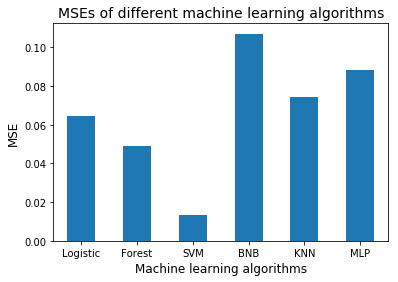

In [40]:
# Draw a bar plot to compare MSEs
ax = MSE_df.plot.bar(x='method', y='MSE', rot=0, legend=None)
ax.set_title("MSEs of different machine learning algorithms", fontsize=14)
ax.set_xlabel("Machine learning algorithms", fontsize=12)
ax.set_ylabel("MSE", fontsize=12)
plt.show()

### Export the dataframe

In [41]:
# Construct a new dataframe for export
full_df = ml_df.append(pr_df)
hardcode_indicator = ~full_df['overconfidence_logit'].notnull()
full_df.loc[hardcode_indicator, 'overconfidence_logit'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_forest'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_svm'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_bnb'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_knn'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_mlp'] = full_df.loc[hardcode_indicator, 'overconfidence']

In [42]:
# export the dataframe
full_df.to_csv(address + 'overconfidence_measure.csv', index=False)